# Exploratory Analysis Notebook

## 1. Introduction

## 2. Environment Setup and Library Imports

In [1]:
# Libraries
import warnings
import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import r2_score
import folium
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
from sklearn.preprocessing import MinMaxScaler

# Set-up environment
pd.options.display.float_format = '{:.2f}'.format
pd.set_option('display.max_colwidth', None)
sns.set_theme(style="whitegrid", context="paper")
os.chdir('/Users/nataschajademinnitt/Documents/5. Data Analysis/open_classrooms/project_5')
print("Current directory:", os.getcwd())
warnings.filterwarnings("ignore")

Current directory: /Users/nataschajademinnitt/Documents/5. Data Analysis/open_classrooms/project_5


## 3. Load Data

In [3]:
# Load the data
df_orders = pd.read_csv("./data/processed/composite_table.csv")
df_customers = pd.read_csv("./data/processed/customers.csv")

# Merging customers onto orders
df_merged = pd.merge(df_orders, df_customers[['customer_id', 'customer_unique_id']], on='customer_id', how='left')
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96478 entries, 0 to 96477
Data columns (total 16 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   customer_id               96478 non-null  object 
 1   customer_zip_code_prefix  96478 non-null  int64  
 2   customer_state            96478 non-null  object 
 3   geolocation_lat           96214 non-null  float64
 4   geolocation_lng           96214 non-null  float64
 5   order_id                  96478 non-null  object 
 6   s_delivery_diff           96470 non-null  float64
 7   f_products                96478 non-null  int64  
 8   f_orders                  96478 non-null  int64  
 9   m_price                   96478 non-null  float64
 10  m_freight                 96478 non-null  float64
 11  s_review_score            95832 non-null  float64
 12  s_review_count            95832 non-null  float64
 13  order_purchase_timestamp  96478 non-null  object 
 14  m_cred

### 3.1 Product Category Popularity Scoring

This feature allocates a score to the 73 product categories based on their popularity, which is determined by the recency of their purchase (days since last purchase) and the frequency (count of product_id in order_items). The time scope is 1 year since the most recent purchase date.

In [5]:
df_product_scores = pd.read_csv("./data/processed/product_score_table.csv")

# Normalize columns
cols = ['recency', 'frequency']
scaler = MinMaxScaler()
df_product_scores[cols] = scaler.fit_transform(df_product_scores[cols])

# Compute a combined “product score”
a = df_product_scores['recency']
b = df_product_scores['frequency']

df_product_scores['product_score'] = (1 / (1 + a)) + b  # reverse score recency

df_product_scores.sort_values('product_score', ascending=False)

,product_category_name,frequency,recency,product_score
14,cama_mesa_banho,1.00,0.04,1.96
12,beleza_saude,0.93,0.03,1.90
33,esporte_lazer,0.76,0.04,1.72
45,informatica_acessorios,0.74,0.03,1.70
55,moveis_decoracao,0.71,0.04,1.67
...,...,...,...,...
53,moveis_colchao_e_estofado,0.00,0.44,0.70
69,tablets_impressao_imagem,0.00,0.62,0.62
38,fashion_roupa_infanto_juvenil,0.00,0.66,0.60
18,cds_dvds_musicais,0.00,0.98,0.51


In [7]:
# Merge with df_products_raw
df_products_raw = pd.read_csv("./data/processed/product_order_table.csv")

df_product_raw_scored = df_products_raw.merge(
    df_product_scores[['product_category_name', 'product_score']],
    on='product_category_name',
    how='left'
)

# Group by most common category
order_product_code = (
    df_product_raw_scored
      .groupby('order_id')['product_score']
      .agg(lambda x: x.mode()[0] if not x.mode().empty else np.nan)
      .reset_index()
)

# Merge onto df_merged
df = df_merged.merge(
    order_product_code,
    on='order_id',
    how='left'
)

When allocating product category scores to order_ids in the merged_df, there are instances where an order_id is associated with more than one category. The most frequent category in an order is selected, in a few instances, there is no single most frequent category, in which case the most popular category is selected as the default.

In [9]:
# Check instances of multiple categories for an order_id
order_score_counts = (
    df_product_raw_scored
      .groupby('order_id')['product_score']
      .nunique()
      .reset_index(name='n_unique_scores')
)

multi_score_orders = order_score_counts[order_score_counts['n_unique_scores'] > 1]

n_multi = multi_score_orders.shape[0]
total_orders = order_score_counts.shape[0]

print(f"{n_multi} orders out of {total_orders} "
      f"({n_multi/total_orders:.1%}) have more than one product_score.")

786 orders out of 98666 (0.8%) have more than one product_score.


## 4. Data Cleaning and Filtering

**Filter for a 1 year timeframe**

By filtering for 1 year we account for seasonal variation.

In [11]:
# Removing the time string
df['order_purchase_timestamp'] = pd.to_datetime(df['order_purchase_timestamp'])

orders_per_year = (
    df
    .groupby(df['order_purchase_timestamp'].dt.year)
    .size()
    .rename('order_count')
)
print(orders_per_year)

# One year before the latest purchase
cutoff = df['order_purchase_timestamp'].max() - pd.DateOffset(years=1)
df = df[df['order_purchase_timestamp'] >= cutoff]

print(f"Filtering for orders on or after {cutoff.date()}")
print(df['order_purchase_timestamp'].min(), "to", df['order_purchase_timestamp'].max())

order_purchase_timestamp
2016      267
2017    43428
2018    52783
Name: order_count, dtype: int64
Filtering for orders on or after 2017-08-29
2017-08-29 15:02:12 to 2018-08-29 15:00:37


**Replace missing values**
1. Replace geolocation_lat and geolocation_lng outside of Brazil with nan
2. Fill geolocation_lat and geolocation_lng nan with KNN imputer zipcodes

In [13]:
# Replace values outside Brazil's approximate bounds with NaN
df.loc[(df['geolocation_lat'] < -33.75116944) | (df['geolocation_lat'] > 5.27438888), 'geolocation_lat'] = np.nan
df.loc[(df['geolocation_lng'] < -73.98283055) | (df['geolocation_lng'] > -34.79314722), 'geolocation_lng'] = np.nan

# Using KNeighborsRegressor to predict longitude and latitude
df_impute = df[df[['geolocation_lat', 'geolocation_lng']].notna().all(axis=1)].copy()

X = df_impute[['customer_zip_code_prefix']]
y = df_impute[['geolocation_lat', 'geolocation_lng']]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42)

knn_reg = KNeighborsRegressor(n_neighbors=5)
knn_reg.fit(X_train, y_train)

y_pred = knn_reg.predict(X_val)

r2 = knn_reg.score(X_val, y_val)
print("R²:", r2)

# Fill numeric values using the KNN imputer
features = ['customer_zip_code_prefix', 'geolocation_lat', 'geolocation_lng']

imputer = KNNImputer(n_neighbors=5)
df[features] = imputer.fit_transform(df[features])

missing_values_after = df[features].isna().sum()
print("Missing values per column after final KNN imputation:")
print(missing_values_after)

R²: 0.9988499693326212
Missing values per column after final KNN imputation:
customer_zip_code_prefix    0
geolocation_lat             0
geolocation_lng             0
dtype: int64


**Additional features**

1. pct_freight: Percentage of total monetary value paid in freight fees
2. recency: Days since last purchase

In [16]:
# New feature: delivery freight percentage
df['m_pct_freight'] =  df['m_freight'] / df['m_price']

lower = df['m_pct_freight'].quantile(0.05)
upper = df['m_pct_freight'].quantile(0.95)

df['m_pct_freight'] = df['m_pct_freight'].clip(lower, upper)

In [18]:
# New feature: recency_days (days since the last purchase)
reference_date = pd.to_datetime(df['order_purchase_timestamp']).max()

df['recency'] = (reference_date - df['order_purchase_timestamp']).dt.days

**Groupby customer_unique_id**

In [20]:
customer_features = df.groupby('customer_unique_id').agg({
    'recency' : 'min',           # Most recent purchase time (Recency)
    'f_orders': 'sum',           # Number of orders (Frequency)
    'f_products': 'sum',         # Number of products ordered (Frequency)
    'm_price' : 'max',           # Max monetary value for products (Monetary)
    'm_freight' : 'max',         # Max monetary value for freight (Monetary)
    'm_pct_freight' : 'max',     # Max proportonal value for freight (Monetary)
    'm_credit' : 'max',          # Max binary for use of credit card (Monetary)
    's_review_score' : 'mean',   # Average review score (Satisfaction)
    's_delivery_diff' : 'mean',  # Delivery expectation difference (Satisfaction)
    'product_score' : lambda x: x.mode()[0] if not x.mode().empty else np.nan,   # Category popularity
    'customer_state' : lambda x: x.mode()[0] if not x.mode().empty else np.nan,  # Location state
    'geolocation_lat' : lambda x: x.mode()[0] if not x.mode().empty else np.nan, # Location lat
    'geolocation_lng' : lambda x: x.mode()[0] if not x.mode().empty else np.nan  # Location long
})

When allocating product category scores to order_ids in the merged_df, there are instances where an order_id is associated with more than one category. The most frequent category in an order is selected, in a few instances, there is no single most frequent category, in which case the most popular category is selected as the default.

In [22]:
# Check instances of multiple categories for an customer_unique_id
order_score_counts = (
    df
      .groupby('customer_unique_id')['product_score']
      .nunique()
      .reset_index(name='n_unique_scores')
)

multi_score_orders = order_score_counts[order_score_counts['n_unique_scores'] > 1]

n_multi = multi_score_orders.shape[0]
total_orders = order_score_counts.shape[0]

print(f"{n_multi} orders out of {total_orders} "
      f"({n_multi/total_orders:.1%}) have more than one product_score.")

964 orders out of 72620 (1.3%) have more than one product_score.


In [30]:
# New feature: delivery difference between expected and actual
conditions = [
    customer_features['s_delivery_diff'] <= -7,
    (customer_features['s_delivery_diff'] > -7) & (customer_features['s_delivery_diff'] < 0),
    customer_features['s_delivery_diff'] == 0,
    (customer_features['s_delivery_diff'] > 0) & (customer_features['s_delivery_diff'] < 7),
    customer_features['s_delivery_diff'] >= 7
]

choices = ['Very early', 'Early', 'On time', 'Late', 'Very late']

customer_features['delivery_diff_grouped'] = np.select(conditions, choices, default='Unknown')

In [34]:
# Replace missing reviews with the average of their delivery_diff_grouped review score
group_means = customer_features.groupby('delivery_diff_grouped')['s_review_score'].transform('mean')

customer_features['s_review_score'] = customer_features['s_review_score'].fillna(group_means)

In [82]:
# New feature: Binary variable for returning customers
customer_features['f_returning'] = np.where(customer_features['f_orders'] == 1, 0, 1)
customer_features['f_returning'].value_counts()

f_returning
0    63875
1     8745
Name: count, dtype: int64

feature: number of items (count), max value price per item in a cart, card (installment, identify premium cards, binary)
regions: main cities vs rest

## 5. Exploratory Data Analysis

In [36]:
customer_features.info()

<class 'pandas.core.frame.DataFrame'>
Index: 72620 entries, 0000366f3b9a7992bf8c76cfdf3221e2 to ffff5962728ec6157033ef9805bacc48
Data columns (total 15 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   recency                   72620 non-null  int64  
 1   f_orders                  72620 non-null  int64  
 2   f_products                72620 non-null  int64  
 3   m_price                   72620 non-null  float64
 4   m_freight                 72620 non-null  float64
 5   m_pct_freight             72620 non-null  float64
 6   m_credit                  72620 non-null  float64
 7   s_review_score            72620 non-null  float64
 8   s_delivery_diff           72613 non-null  float64
 9   product_score             72619 non-null  float64
 10  customer_state            72620 non-null  object 
 11  geolocation_lat           72620 non-null  float64
 12  geolocation_lng           72620 non-null  float64
 13  delivery

In [45]:
# Describe numeric features
features = [
    col for col in customer_features.columns
    if col not in ['geolocation_lat', 'geolocation_lng']
    and customer_features[col].dtype in ('int64','float64')
]

customer_features[features].describe()

,recency,f_orders,f_products,m_price,m_freight,m_pct_freight,m_credit,s_review_score,s_delivery_diff,product_score,avg_review_score_imputed
count,72620.00,72620.00,72620.00,72620.00,72620.00,72620.00,72620.00,72620.00,72613.00,72619.00,72620.00
mean,172.57,1.18,1.07,138.93,23.22,0.29,0.78,4.13,-10.48,1.48,4.13
std,100.07,0.62,0.31,209.07,22.34,0.21,0.42,1.30,9.91,0.32,1.30
min,0.00,1.00,1.00,0.85,0.00,0.05,0.00,1.00,-146.02,0.50,1.00
25%,88.00,1.00,1.00,47.59,13.79,0.13,1.00,4.00,-15.47,1.24,4.00
50%,172.00,1.00,1.00,89.00,17.63,0.23,1.00,5.00,-11.13,1.58,5.00
75%,260.00,1.00,1.00,149.99,24.55,0.38,1.00,5.00,-6.11,1.72,5.00
max,364.00,24.00,13.00,13440.00,1794.96,0.83,1.00,5.00,188.98,1.96,5.00


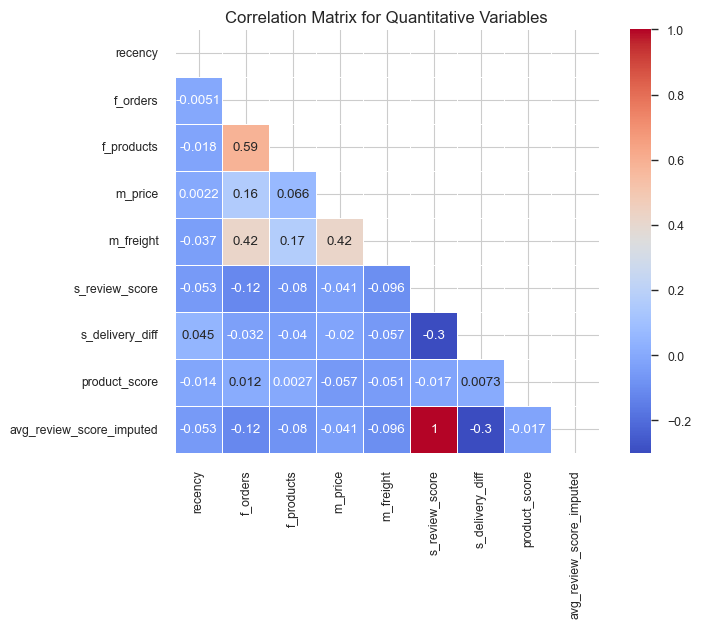

In [51]:
# Correlation matrix
features = [
    col for col in customer_features.columns
    if col not in ['geolocation_lat', 'geolocation_lng', 'm_pct_freight', 'm_credit']
    and customer_features[col].dtype in ('int64','float64')
]

corr = customer_features[features].corr()

# Plot
mask = np.triu(corr)
sns.heatmap(corr, annot=True, cmap='coolwarm', mask=mask, linewidths=.5, cbar=True, square=True)
plt.title("Correlation Matrix for Quantitative Variables", fontsize=12)
plt.show()

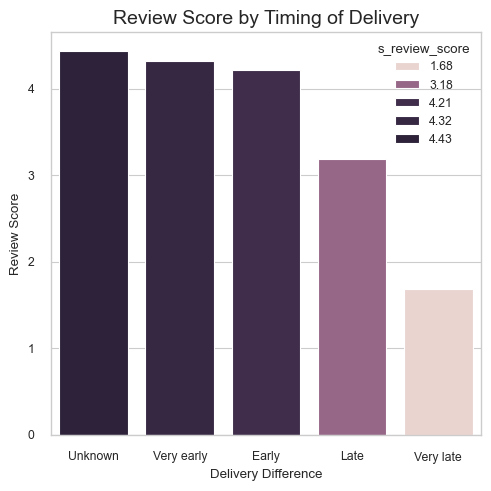

In [53]:
# Review Score by Timing of Delivery
check = customer_features.groupby(['delivery_diff_grouped']).agg({
    's_review_score': 'mean'})

check = check.sort_values('s_review_score', ascending=False).reset_index().round(2)

# Plot
plt.figure(figsize=(5, 5))
sns.barplot(y='s_review_score', x='delivery_diff_grouped', hue='s_review_score', data=check)
plt.title('Review Score by Timing of Delivery', fontsize=14)
plt.xlabel('Delivery Difference')
plt.ylabel('Review Score')
plt.tight_layout()
plt.savefig(f"./results/figures/Review_Score_by_Timing_of_Delivery.png")
plt.show()

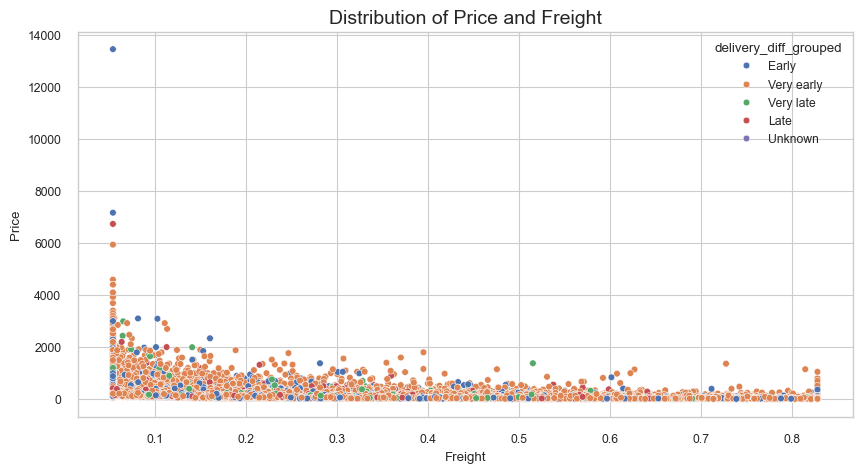

In [61]:
# Distribution of Price and Freight
plt.figure(figsize=(10,5))
sns.scatterplot(data=customer_features, y='m_price', x='m_pct_freight', hue='delivery_diff_grouped')
plt.xlabel("Freight")
plt.ylabel("Price")
plt.title("Distribution of Price and Freight", fontsize=14)
plt.savefig(f"./results/figures/Distribution_of_Price_and_Freight.png")
plt.show()

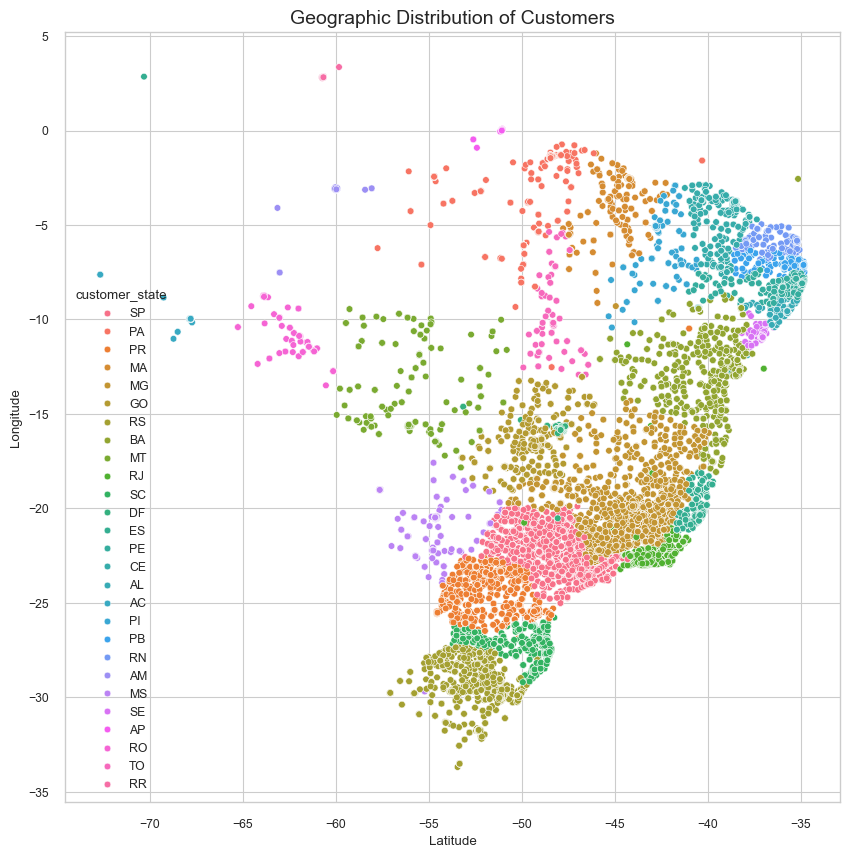

In [63]:
# Geographic spread of customers
plt.figure(figsize=(10,10))
sns.scatterplot(data=customer_features, y='geolocation_lat', x='geolocation_lng', hue='customer_state')
plt.xlabel("Latitude")
plt.ylabel("Longitude")
plt.title("Geographic Distribution of Customers", fontsize=14)
plt.savefig(f"./results/figures/Geographic_Distribution_of_Customers.png")
plt.show()

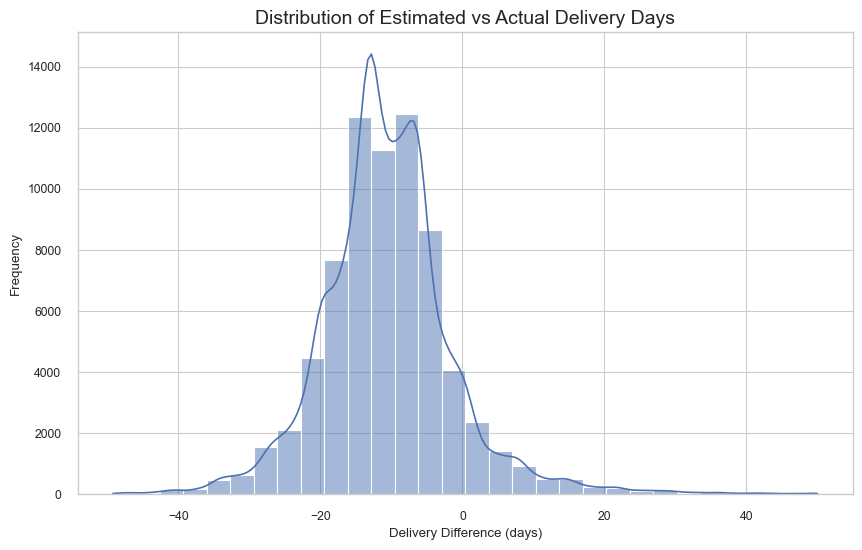

In [65]:
# Distribution of Delivery Difference
df_plot = customer_features[customer_features['s_delivery_diff'].between(-50, 50)]
plt.figure(figsize=(10,6))
sns.histplot(df_plot['s_delivery_diff'], bins=30, kde=True)
plt.xlabel("Delivery Difference (days)")
plt.ylabel("Frequency")
plt.title("Distribution of Estimated vs Actual Delivery Days", fontsize=14)
plt.savefig(f"./results/figures/Distribution_of_Estimated_Actual_Delivery_Days.png")
plt.show()

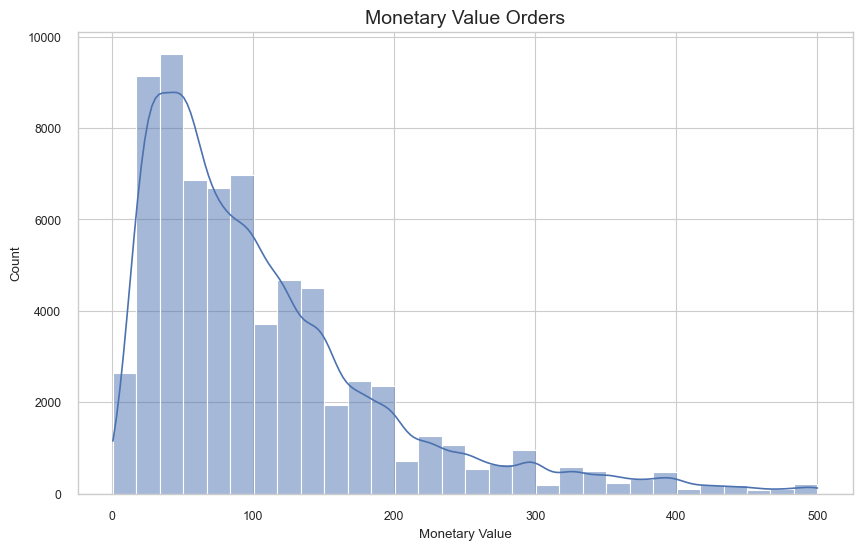

In [69]:
# Distribution of monetary value
df_plot = customer_features[customer_features['m_price'] < 500]
plt.figure(figsize=(10,6))
sns.histplot(df_plot['m_price'], bins=30, kde=True)
plt.xlabel("Monetary Value")
plt.ylabel("Count")
plt.title("Monetary Value Orders", fontsize=14)
plt.savefig(f"./results/figures/Monetary_Value_Orders.png")
plt.show()

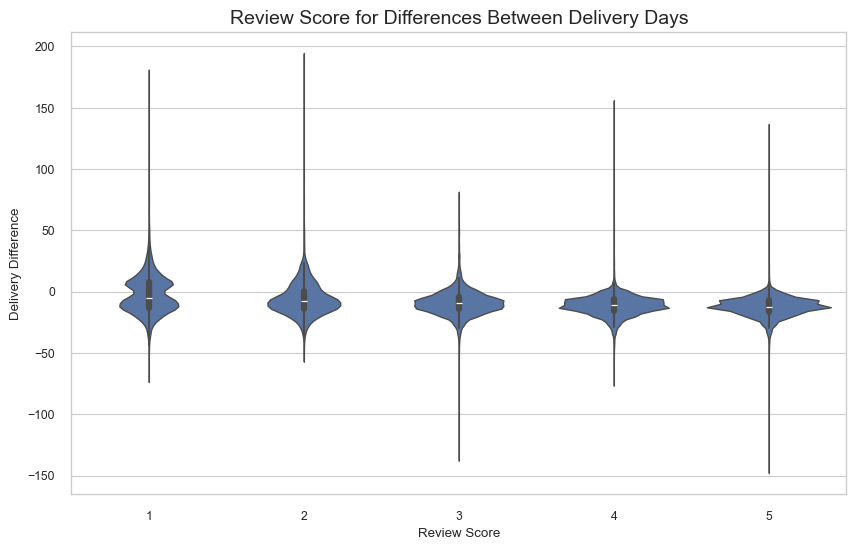

In [71]:
# Review scores against delivery time difference
customer_features['rounded_review_score'] = customer_features['s_review_score'].round(0)

plt.figure(figsize=(10,6))
sns.violinplot(data=customer_features, y='s_delivery_diff', x='rounded_review_score')
plt.xticks(ticks=[0, 1, 2, 3, 4], labels=['1', '2', '3', '4', '5'])
plt.xlabel("Review Score")
plt.ylabel("Delivery Difference")
plt.title("Review Score for Differences Between Delivery Days", fontsize=14)
plt.savefig(f"./results/figures/Review_Score_for_Differences_Between_Delivery_Days.png")
plt.show()

## 6. Feature Engineering

We applied a log scale to spending so that differences between 10 and 100 matter similarly to differences between 1,000 and 10,000. This helps our algorithm see both small and large spenders fairly.

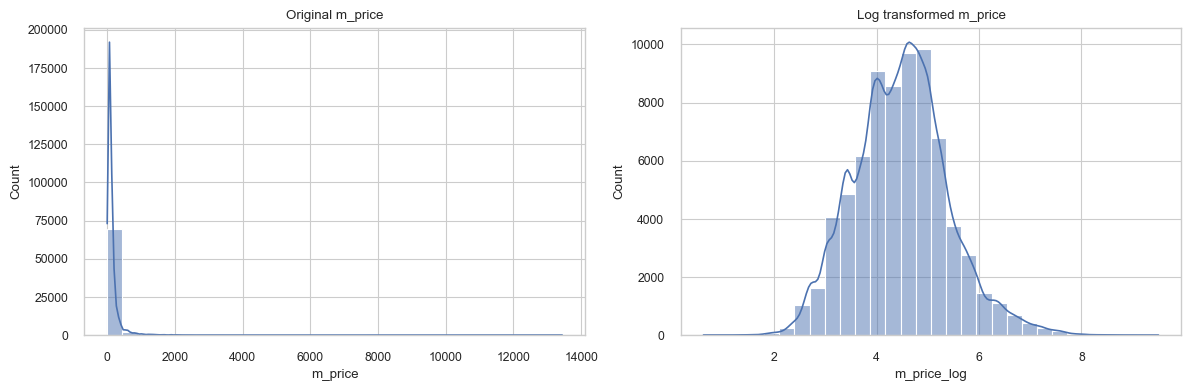

In [84]:
# Log transform total_price
df_fea = customer_features.copy()
df_fea['m_price_log'] = np.log1p(df_fea['m_price'])

pairs = [('m_price', 'm_price_log')]

for orig, trans in pairs:
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    sns.histplot(df_fea[orig], kde=True, bins=30, ax=axes[0])
    axes[0].set_title(f'Original {orig}')
    sns.histplot(df_fea[trans], kde=True, bins=30, ax=axes[1])
    axes[1].set_title(f'Log transformed {orig}')
    plt.tight_layout()
    plt.savefig(f"./results/figures/log_transformation_{orig}.png")
    plt.show()

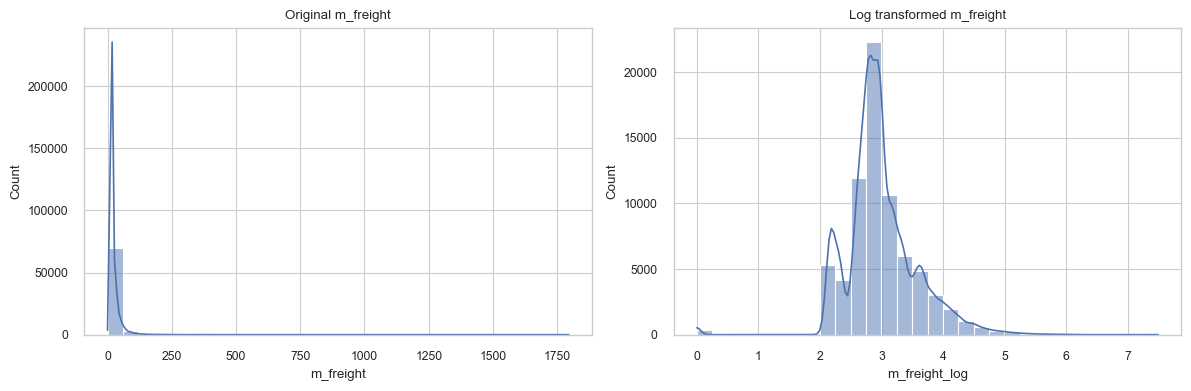

In [86]:
# Log transform total_freight
df_fea['m_freight_log'] = np.log1p(df_fea['m_freight'])

pairs = [('m_freight', 'm_freight_log')]

for orig, trans in pairs:
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    sns.histplot(df_fea[orig], kde=True, bins=30, ax=axes[0])
    axes[0].set_title(f'Original {orig}')
    sns.histplot(df_fea[trans], kde=True, bins=30, ax=axes[1])
    axes[1].set_title(f'Log transformed {orig}')
    plt.tight_layout()
    plt.savefig(f"./results/figures/log_transformation_{orig}.png")
    plt.show()

Because most deliveries were very early, we group them to reduce skew.

## 7. Export

Keep outliers for monetary and delivery diff
use standard scalar / robust scalar -> look at inertia values 
look without states

In [92]:
df_fea.columns

Index(['recency', 'f_orders', 'f_products', 'm_price', 'm_freight',
       'm_pct_freight', 'm_credit', 's_review_score', 's_delivery_diff',
       'product_score', 'customer_state', 'geolocation_lat', 'geolocation_lng',
       'delivery_diff_grouped', 'avg_review_score_imputed',
       'rounded_review_score', 'f_returning', 'm_price_log', 'm_freight_log'],
      dtype='object')

In [102]:
selected_columns = ['recency', 
                    'f_orders', 
                    'f_products',
                    'f_returning',
                    'm_price_log', 
                    'm_freight_log',
                    'm_pct_freight', 
                    'm_credit', 
                    's_review_score', 
                    's_delivery_diff',
                    'product_score',
                   ]

df_selected = df_fea[selected_columns]

df_selected = df_selected.dropna()

df_selected.info()

<class 'pandas.core.frame.DataFrame'>
Index: 72612 entries, 0000366f3b9a7992bf8c76cfdf3221e2 to ffff5962728ec6157033ef9805bacc48
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   recency          72612 non-null  int64  
 1   f_orders         72612 non-null  int64  
 2   f_products       72612 non-null  int64  
 3   f_returning      72612 non-null  int64  
 4   m_price_log      72612 non-null  float64
 5   m_freight_log    72612 non-null  float64
 6   m_pct_freight    72612 non-null  float64
 7   m_credit         72612 non-null  float64
 8   s_review_score   72612 non-null  float64
 9   s_delivery_diff  72612 non-null  float64
 10  product_score    72612 non-null  float64
dtypes: float64(7), int64(4)
memory usage: 6.6+ MB


In [104]:
df_selected.to_csv('./data/processed/processed_database.csv', index=False)

Best parameters: {'n_clusters': 5, 'n_init': 10, 'tol': 0.001} with silhouette score: 0.391951730710731

**Refine your feature engineering for segmentation:**

Review and Transform Distributions:
* Outlier Treatment: Double-check distributions for features like recency_days, monetary_value_log, and delivery_diff. Consider capping extreme values or applying additional transformations if necessary.
* Non-linear Transformations: If any continuous feature is still skewed (even after log transformation), you might try additional transforms (e.g., square root) or use binning to capture non-linear effects.

Enhance Frequency Measures:
* RFM Metrics: Although many customers have only one purchase, you might still consider combining recency, frequency, and monetary value into a composite RFM score. If possible, explore longer time windows or derive additional frequency-related metrics (e.g., days between purchases) for those few returning customers.
* Binary vs. Continuous: You already have a binary indicator for returning customers. You might also explore whether a continuous measure (or a few bins for frequency, such as 1, 2–3, 4+) adds nuance.

Refine Delivery Performance Features:
* Continuous vs. Categorical: You currently use a categorical variable for delivery_diff_grouped. Consider whether keeping a continuous version (possibly capped) alongside the categorical version might provide extra insight. You could even try interaction terms with other variables (e.g., does late delivery combined with low monetary value drive lower satisfaction?).
* Ordinal Encoding vs. One-Hot Encoding: Revisit your choice for encoding delivery_diff_grouped. A custom ordinal mapping might capture the inherent order, but one-hot encoding could be used if you want to avoid imposing a numeric distance when it might not be linear.

Geographic Features:
* Coordinate Transformation: Although you have latitude and longitude, consider if a transformation (e.g., projecting to a coordinate system like UTM) would yield more meaningful Euclidean distances.
* Additional Location Info: If available, features like customer_state or region might capture socio-economic or cultural differences that influence purchasing behavior.

Interaction Features:
* Consider creating interaction features that might capture important customer behaviors, such as:
monetary_value_log * recency_days: Could indicate how long a high spender goes without purchasing.
delivery_diff (continuous) * avg_review_score_imputed: To see if the effect of delivery performance is more pronounced in certain segments.

Dimensionality Reduction:
* If you end up with many derived features, using techniques like PCA can help you visualize which components capture the most variance, potentially guiding further feature selection.